# Dimensionality Reduction

## PCA

PCA aims to detect correlation between variables. PCA is all about *finding the directions of maximum variance in a high-dimensional data & project it onto a smaller dimensional subspace by dropping "less informative" eigenpairs.*


#### Properties
1. Linear transformation technique
2. Unsupervised in nature, as it ignores class labels

#### Algorithm
1. Standardize the data.
2. Obtain *Eigenvectors and Eigenvalues* from the covariance matrix or correlation matrix, or perform Singular Value Decomposition.
3. Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace (k≤d).
4. Construct the projection matrix W from the selected k eigenvectors.
5. Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

In [2]:
from pprint import pprint

In [3]:
iris = load_iris()

In [4]:
X = iris['data']
y = iris['target']

In [5]:
print(f'Training Sample: {len(X)}')
print(f'Target Values: {len(y)}')

Training Sample: 150
Target Values: 150


**1. Standardizing the data**

In [6]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

**2. Calcualting Eigenvectors & EigenValues from covariance matrix**

In [7]:
cov_mat = np.cov(X_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

**3. Sort Eigenvalues & Eigenvectors pairs in descending order of Eigenvalues**

In [8]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

eigen_pairs.sort(key=lambda k: k[0], reverse=True)

### Total & Explained Variance

In [10]:
total_variance = sum(eigen_vals)

In [11]:
exp_var = [(i/total_variance)*100 for i in sorted(eigen_vals, reverse=True)]

In [13]:
cum_exp_var = np.cumsum(exp_var)

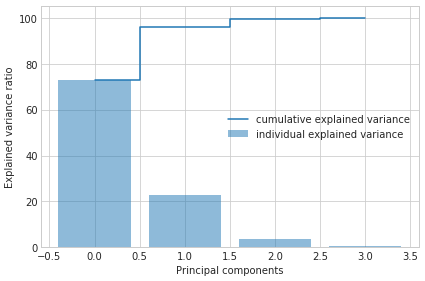

In [15]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), exp_var, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_exp_var, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [16]:
cum_exp_var

array([ 72.96244541,  95.8132072 ,  99.48212909, 100.        ])

*The first 2 dimensions are capable of explaining ~96% of the total data variance.*

**4. Creating Projection Matrix (W) from Eigenvectors**

Projection Matrix is essentially a matrix of top *K* concatenated Eigenvectors

In [25]:
eigen_pairs[0][1]

array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654])

In [21]:
eigen_pairs[0][1].shape

(4,)

In [23]:
proj_matrix = np.hstack((eigen_pairs[0][1].reshape(4, 1),
                       eigen_pairs[1][1].reshape(4, 1)))

In [24]:
proj_matrix

array([[ 0.52106591, -0.37741762],
       [-0.26934744, -0.92329566],
       [ 0.5804131 , -0.02449161],
       [ 0.56485654, -0.06694199]])

**5. Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.**

In [26]:
X_pca = X_std.dot(proj_matrix)

In [28]:
X_pca.shape

(150, 2)

### Using Sklearn

In [30]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=2)
X_sklearn_pca = pca.fit_transform(X_std)

In [34]:
X_sklearn_pca.shape

(150, 2)

In [38]:
print(f'Explained Variance: {sum(pca.explained_variance_ratio_)}')

Explained Variance: 0.9581320720000165


## Linear Discriminant Analysis

*The goal is to project a dataset onto a lower-dimensional space with good class-separability in order avoid overfitting and reduce computational cost. The goal of an LDA is to project a feature space (a dataset n-dimensional samples) onto a smaller subspace k (where k≤n−1) while maintaining the class-discriminatory information.*

#### Properties
* Supervised in nature

#### Algorithm
1. Compute the *d-dimensional* mean vectors for the different classes from the dataset.
2. Compute the scatter matrices (in-between-class and within-class scatter matrix).
3. Compute the eigenvectors *(e1,e2,...,ed)* and corresponding eigenvalues *(λ1,λ2,...,λd)* for the scatter matrices as  $S_{W}^{-1}S_B$
4. Sort the eigenvectors by decreasing eigenvalues and choose _k_ eigenvectors with the largest eigenvalues to form a *d×k dimensional matrix W* (where every column represents an eigenvector).
5. Use this *d×k* eigenvector matrix to transform the samples onto the new subspace. 

**1. Calculating d-dimensional mean vector for each class**

In [45]:
mean_vectors = []
for cl in range(3):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 0: [5.006 3.428 1.462 0.246]

Mean Vector class 1: [5.006 3.428 1.462 0.246]

Mean Vector class 2: [5.936 2.77  4.26  1.326]



In [46]:
mean_vectors

[array([5.006, 3.428, 1.462, 0.246]),
 array([5.936, 2.77 , 4.26 , 1.326]),
 array([6.588, 2.974, 5.552, 2.026])]

**2. Calculating Scatter Matrices**

*Within-Class Scatter Matrix*

In [58]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(3), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print(f'Within-Class Scatter Matrix:\n {S_W}')

Within-Class Scatter Matrix:
 [[38.9562 13.63   24.6246  5.645 ]
 [13.63   16.962   8.1208  4.8084]
 [24.6246  8.1208 27.2226  6.2718]
 [ 5.645   4.8084  6.2718  6.1566]]


*Between-Class Scatter Matrix*

$$S_B =  \sum\limits_{i=1}^{c} N_{i} (\pmb m_i - \pmb m) (\pmb m_i - \pmb m)^T$$
where, 
* $m$ - Overall mean of the dataset
* $m_i$ - Mean for class $i$
* $N_i$ - Number of samples of class $i$

In [59]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print(f'Between-Class Scatter Matrix:\n {S_B}')

Between-Class Scatter Matrix:
 [[ 35.48571111 -16.84988889  98.4518      40.49977778]
 [-16.84988889  10.99771111 -49.7646     -19.48822222]
 [ 98.4518     -49.7646     276.181      112.622     ]
 [ 40.49977778 -19.48822222 112.622       46.24444444]]


**3.Calculating Eigenvalues & Eigenvectors for $S_{W}^{-1}S_B$**

In [60]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [61]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

In [62]:
total_variance = sum(eigen_vals)
exp_var = [(i/total_variance)*100 for i in sorted(eigen_vals, reverse=True)]
cum_exp_var = np.cumsum(exp_var)

In [63]:
print(f"Cumulative Explained Variance: {cum_exp_var}")

Cumulative Explained Variance: [ 72.96244541  95.8132072   99.48212909 100.        ]


**4.Choosing k eigenvectors with the largest eigenvalues**

In [64]:
proj_matrix = np.hstack((eigen_pairs[0][1].reshape(4, 1),
                       eigen_pairs[1][1].reshape(4, 1)))

In [65]:
print(f"Projection Matrix\n{proj_matrix}")

Projection Matrix
[[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


**5. Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.**

In [67]:
X_lda = X.dot(proj_matrix)

In [68]:
X_lda.shape

(150, 2)

### Using Sklearn

In [69]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [70]:
lda = LinearDiscriminantAnalysis(n_components=2)

In [72]:
X_sklearn_lda = lda.fit_transform(X_std, y)

In [73]:
X_sklearn_lda.shape

(150, 2)

In [74]:
X_sklearn_lda.__dir__()

['__repr__',
 '__hash__',
 '__str__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__iter__',
 '__add__',
 '__radd__',
 '__sub__',
 '__rsub__',
 '__mul__',
 '__rmul__',
 '__mod__',
 '__rmod__',
 '__divmod__',
 '__rdivmod__',
 '__pow__',
 '__rpow__',
 '__neg__',
 '__pos__',
 '__abs__',
 '__bool__',
 '__invert__',
 '__lshift__',
 '__rlshift__',
 '__rshift__',
 '__rrshift__',
 '__and__',
 '__rand__',
 '__xor__',
 '__rxor__',
 '__or__',
 '__ror__',
 '__int__',
 '__float__',
 '__iadd__',
 '__isub__',
 '__imul__',
 '__imod__',
 '__ipow__',
 '__ilshift__',
 '__irshift__',
 '__iand__',
 '__ixor__',
 '__ior__',
 '__floordiv__',
 '__rfloordiv__',
 '__truediv__',
 '__rtruediv__',
 '__ifloordiv__',
 '__itruediv__',
 '__index__',
 '__matmul__',
 '__rmatmul__',
 '__imatmul__',
 '__len__',
 '__getitem__',
 '__setitem__',
 '__delitem__',
 '__contains__',
 '__new__',
 '__array__',
 '__array_prepare__',
 '__array_wrap__',
 '__array_ufunc__',
 '__array_function__',
 '__sizeof__',
 